# **Applied Data Science Capstone Battle of Neighborhoods:**


### Popular Latin Neighborhoods in Toronto 

# **1. Introduction and Business Problem**

This project is catered to Latinos who are seeking to immigrate to Canada. Leveraging data from Foursquare and Wikipedia, I will apply data science and python to explore Latin Venues and compare the various neighborhoods in Toronto.

Canada is a large country, therefore this project is focused on Toronto, ON as it has largest Latin American Population.

# **2. Data and Resources**

### **2.1 Links:**
>- Latin Demographic Data Link: https://en.wikipedia.org/wiki/Latin_American_Canadians
>- Location Data: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

### **2.2 Resources:**
>- Foursquare.com database to explore and search various venues and to compare neighborhoods in Toronto
>- BeautifulSoup Python package for parsing HTML documents
>- Geopy  to locate coordinates of Toronto Postal Codes
>- Folium for mapping visualization
>- matplotlib to create a barchart for visualization
>- from sklearn.cluster import KMEANS to explore and analyze the Neighborhoods 

### **2.3 Libraries**

First lets import all the libraries and application to run our code:

In [1]:
import re
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen


#import matplot libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

import requests # library to handle requests
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



# **3. 2016 Latin American Canadian Population by Province:**

### **3.1 First collect the Demographic data set I will need to create the URL, then apply the **BeautifulSoup** package to extract and parse html data from Wikipedia**

In [2]:
#scrape the Wikipedia https://en.wikipedia.org/wiki/Latin_American_Canadians
url1 = 'https://en.wikipedia.org/wiki/Latin_American_Canadians'
html1 = urlopen(url1).read().decode('utf-8')
tables1 = BeautifulSoup(html1, 'html.parser')

### **3.2 Second wrangle the parsed HTML data and clean it, to create the datafrome relecting Province and Population**

In [3]:
#wrangle the data
tables1 = tables1.find('table', class_='wikitable sortable')
data1 = tables1.find_all('td')

# clean data and read it into a pandas dataframe

province = []
latin_americans_2016= []
pct_2016 = []

for i in range(0, len(data1), 7):
    province.append(data1[i].text.strip())
    latin_americans_2016.append(data1[i+5].text.strip())
            
prov_df = pd.DataFrame(data=[province, latin_americans_2016]).transpose()
prov_df.columns = ['Province', 'Latin_Americans_2016']
print('Dataframe created: Note population has a comma, which will need to be converted to a string')
prov_df.head()

Dataframe created: Note population has a comma, which will need to be converted to a string


,Province,Latin_Americans_2016
0,Ontario,"195,950"
1,Québec,"133,920"
2,Alberta,"55,090"
3,British Columbia,"44,115"
4,Manitoba,"9,895"


### **3.3 Third convert the population from String to integer**  
##### First I copied the prov_df, and droped the total canadian population, next I assigned the populaton to string, which allows you to replace the comma string with nothing which allows python to see it as numeric, Finally I set astype integer

In [4]:
#convert numbers with cammos from string to integer by stripping the comma
prov_df2 = prov_df.drop(13)

prov_df2['Latin_Americans_2016'] = prov_df2['Latin_Americans_2016'].astype('str')
prov_df2['Latin_Americans_2016'] = prov_df2['Latin_Americans_2016'].str.replace(',','')
prov_df2['Latin_Americans_2016'] = prov_df2['Latin_Americans_2016'].astype(int)
print('New Dataframe with no comma!')
prov_df.head()

New Dataframe with no comma!


,Province,Latin_Americans_2016
0,Ontario,"195,950"
1,Québec,"133,920"
2,Alberta,"55,090"
3,British Columbia,"44,115"
4,Manitoba,"9,895"


### **3.4 The final step is to visualize the Latin American Population by using matplotlib**

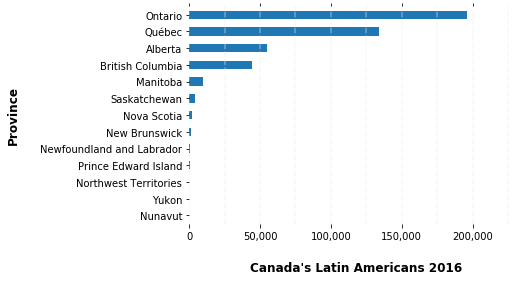

In [5]:
#use matplotlib to convert the province today to a barchart for visualization
bar_prov = prov_df2.sort_values('Latin_Americans_2016', ascending=True).set_index('Province')

bar_prov = bar_prov.plot(kind='barh')

#despine
bar_prov.spines['right'].set_visible(False)
bar_prov.spines['top'].set_visible(False)
bar_prov.spines['left'].set_visible(False)
bar_prov.spines['bottom'].set_visible(False)
#switch off ticks
bar_prov.tick_params(axis='both', which='both', bottom='off', top='on', labelleft='on', labelbottom='on')

#set x-axis
vals = bar_prov.get_xticks()
for tick in vals:
    bar_prov.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
bar_prov.set_xlabel("Canada's Latin Americans 2016", labelpad=20, weight='bold', size=12)

# Set y-axis label
bar_prov.set_ylabel('Province', labelpad=20, weight='bold', size=12)

# Format y-axis label
bar_prov.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

bar_prov.get_legend().remove()
bar_prov

# **4. Where to find the Latin Venues**

### **4.1 First sign into the Foursquare API with your credentials:**
Note: credentials were "removed" due to privacy

In [6]:
#Apply Foursquare API credentials
CLIENT_ID = 'REMOVED' # your Foursquare ID
CLIENT_SECRET = 'REMOVED' # your Foursquare Secret
VERSION = '20200804'
LIMIT = 150

### **4.2 Second Lets create the Latitude and longitude of Toronto**

In [7]:
#find Toronto Latitude and Longitude
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Latitude and Longitude values of {} are {}, {}'.format(address,
                                                               latitude,
                                                               longitude))

Latitude and Longitude values of Toronto, ON are 43.6534817, -79.3839347


### **4.3 Third search for Latin venues within a 5000 radius of Toronto, ON**

#### **To focus on venues that target the Latin Demographic I will search for two key words "Mexican and Latin"**

#### **Conduct the first key word search and create the first latin venue dataframe**

In [8]:
#first search for any venue with word Mexican within a 5000 radius
search_query = 'Mexican'
radius = 5000

#get url
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

#get resluts
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
Latin_DF = json_normalize(venues)
print('First Dataframe created using search word Mexican')
Latin_DF.head()

First Dataframe created using search word Mexican


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,4adc9148f964a520512d21e3,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1596670313,False,"323 Yonge St, Unit 114",Yonge & Dundas,43.656860,-79.380910,"[{'label': 'display', 'lat': 43.65686, 'lng': ...",448,M5B 1R7,CA,Toronto,ON,Canada,"[323 Yonge St, Unit 114 (Yonge & Dundas), Toro..."
1,4f7d9a0ee4b01f9f43bd0603,Mexican Consulate,"[{'id': '4bf58dd8d48988d12c951735', 'name': 'E...",v-1596670313,False,11 King St,NaN,43.648942,-79.378676,"[{'label': 'display', 'lat': 43.64894155562399...",659,NaN,CA,Toronto,ON,Canada,"[11 King St, Toronto ON, Canada]"
2,4ae623e3f964a52002a521e3,Quesada Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1596670313,False,92 King Street E,at Church St,43.649939,-79.374496,"[{'label': 'display', 'lat': 43.64993863703611...",856,M5C 2V8,CA,Toronto,ON,Canada,"[92 King Street E (at Church St), Toronto ON M..."
3,4e78ced2887738167d934c2d,Mucho Burrito Fresh Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1596670313,False,"220 Yonge St,",Eaton Centre,43.655323,-79.381509,"[{'label': 'display', 'lat': 43.655323, 'lng':...",283,M5B 2H1,CA,Toronto,ON,Canada,"[220 Yonge St, (Eaton Centre), Toronto ON M5B ..."
4,564bba99498ee9b036cb3e69,Spiceman Mexican,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1596670313,False,596 College St.,Clinton,43.655241,-79.413843,"[{'label': 'display', 'lat': 43.655241, 'lng':...",2416,NaN,CA,Toronto,ON,Canada,"[596 College St. (Clinton), Toronto ON, Canada]"


#### **Conduct the second key word search and create the second latin venue dataframe**

In [9]:
#second search for any venue with word Latin within a 5000 radius
search_query1 = 'Latin'
radius1 = 5000

#get url
url1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query1, radius1, LIMIT)

#get results
results1 = requests.get(url1).json()

# assign relevant part of JSON to venues
venues1 = results1['response']['venues']

# tranform venues into a dataframe
Latin_DF1 = json_normalize(venues1)
print('Second Dataframe created using search word Latin')
Latin_DF1.head()

Second Dataframe created using search word Latin


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id
0,51ee9af9498e52f163fef9fa,Latin Taste,"[{'id': '4bf58dd8d48988d1be941735', 'name': 'L...",v-1596670320,False,200 Baldwin Steet,Augusta,43.654632,-79.401547,"[{'label': 'display', 'lat': 43.65463168932103...",1424,M5T 1L8,CA,Toronto,ON,Canada,"[200 Baldwin Steet (Augusta), Toronto ON M5T 1...",NaN
1,4b65e223f964a52008062be3,Latin American Emporium,"[{'id': '4bf58dd8d48988d1ff941735', 'name': 'M...",v-1596670320,False,243 Augusta Ave,NaN,43.654930,-79.401927,"[{'label': 'display', 'lat': 43.65492968412687...",1458,M5T 2L8,CA,Toronto,ON,Canada,"[243 Augusta Ave, Toronto ON M5T 2L8, Canada]",NaN
2,53165b60498e9a9cf57d31a1,Assist on Latin America,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",v-1596670320,False,586 Yonge Street,NaN,43.671198,-79.389925,"[{'label': 'display', 'lat': 43.67119775204986...",2030,M4Y 1Z3,CA,Toronto,ON,Canada,"[586 Yonge Street, Toronto ON M4Y 1Z3, Canada]",NaN
3,5d588dde33e32700088bf04e,Latin Sparks Festival,"[{'id': '5267e4d9e4b0ec79466e48c7', 'name': 'F...",v-1596670320,False,NaN,NaN,43.644517,-79.352329,"[{'label': 'display', 'lat': 43.644517, 'lng':...",2734,M5A 3L2,CA,Toronto,ON,Canada,"[Toronto ON M5A 3L2, Canada]",NaN
4,4c9e31b72fb1a143d2ebe740,Latin World,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",v-1596670320,False,1229 Bloor St W,NaN,43.658753,-79.440817,"[{'label': 'display', 'lat': 43.65875337351278...",4618,NaN,CA,Toronto,ON,Canada,"[1229 Bloor St W, Toronto ON, Canada]",NaN


#### **Combine the two created Latin Dataframes to get a good number of locations into one dataframe**

In [14]:
# third append the two dataframes
Latin_DF2 = Latin_DF1.append(Latin_DF, ignore_index = True)
print('Combined Latin Dataframes!')
Latin_DF2.head()

Combined Latin Dataframes!


,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1be941735', 'name': 'L...",False,51ee9af9498e52f163fef9fa,200 Baldwin Steet,CA,Toronto,Canada,Augusta,1424,"[200 Baldwin Steet (Augusta), Toronto ON M5T 1...","[{'label': 'display', 'lat': 43.65463168932103...",43.654632,-79.401547,M5T 1L8,ON,Latin Taste,v-1596670320,NaN
1,"[{'id': '4bf58dd8d48988d1ff941735', 'name': 'M...",False,4b65e223f964a52008062be3,243 Augusta Ave,CA,Toronto,Canada,NaN,1458,"[243 Augusta Ave, Toronto ON M5T 2L8, Canada]","[{'label': 'display', 'lat': 43.65492968412687...",43.654930,-79.401927,M5T 2L8,ON,Latin American Emporium,v-1596670320,NaN
2,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",False,53165b60498e9a9cf57d31a1,586 Yonge Street,CA,Toronto,Canada,NaN,2030,"[586 Yonge Street, Toronto ON M4Y 1Z3, Canada]","[{'label': 'display', 'lat': 43.67119775204986...",43.671198,-79.389925,M4Y 1Z3,ON,Assist on Latin America,v-1596670320,NaN
3,"[{'id': '5267e4d9e4b0ec79466e48c7', 'name': 'F...",False,5d588dde33e32700088bf04e,NaN,CA,Toronto,Canada,NaN,2734,"[Toronto ON M5A 3L2, Canada]","[{'label': 'display', 'lat': 43.644517, 'lng':...",43.644517,-79.352329,M5A 3L2,ON,Latin Sparks Festival,v-1596670320,NaN
4,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",False,4c9e31b72fb1a143d2ebe740,1229 Bloor St W,CA,Toronto,Canada,NaN,4618,"[1229 Bloor St W, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.65875337351278...",43.658753,-79.440817,NaN,ON,Latin World,v-1596670320,NaN


### **4.4 Fourth Lets create filtered Data frame that filters the data**

In [15]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in Latin_DF2.columns if col.startswith('location.')] + ['id']
Latin_DF_filtered = Latin_DF2.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
Latin_DF_filtered['categories'] = Latin_DF_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
Latin_DF_filtered.columns = [column.split('.')[-1] for column in Latin_DF_filtered.columns]
print('Filtered Dataframe!')
Latin_DF_filtered.head()

Filtered Dataframe!


,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Latin Taste,Latin American Restaurant,200 Baldwin Steet,CA,Toronto,Canada,Augusta,1424,"[200 Baldwin Steet (Augusta), Toronto ON M5T 1...","[{'label': 'display', 'lat': 43.65463168932103...",43.654632,-79.401547,M5T 1L8,ON,51ee9af9498e52f163fef9fa
1,Latin American Emporium,Miscellaneous Shop,243 Augusta Ave,CA,Toronto,Canada,NaN,1458,"[243 Augusta Ave, Toronto ON M5T 2L8, Canada]","[{'label': 'display', 'lat': 43.65492968412687...",43.654930,-79.401927,M5T 2L8,ON,4b65e223f964a52008062be3
2,Assist on Latin America,Office,586 Yonge Street,CA,Toronto,Canada,NaN,2030,"[586 Yonge Street, Toronto ON M4Y 1Z3, Canada]","[{'label': 'display', 'lat': 43.67119775204986...",43.671198,-79.389925,M4Y 1Z3,ON,53165b60498e9a9cf57d31a1
3,Latin Sparks Festival,Festival,NaN,CA,Toronto,Canada,NaN,2734,"[Toronto ON M5A 3L2, Canada]","[{'label': 'display', 'lat': 43.644517, 'lng':...",43.644517,-79.352329,M5A 3L2,ON,5d588dde33e32700088bf04e
4,Latin World,Mexican Restaurant,1229 Bloor St W,CA,Toronto,Canada,NaN,4618,"[1229 Bloor St W, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.65875337351278...",43.658753,-79.440817,NaN,ON,4c9e31b72fb1a143d2ebe740


### **4.5 Fifth Clean the dataframe to only reflect Name, Category, Latitude Longitude and Postal Code.**
##### Note: In order to merge the postal code to the Toronto Dataframe (created in the next section), I will need to strip the postal code column so that only the first three variables are left.

In [16]:
#Reset index and clean data
Lat_df = Latin_DF_filtered.reset_index()
Lat_df = Lat_df[['name', 'categories', 'lat', 'lng', 'postalCode']]

#Create new Postal Code column from the Stripped postal code column
Lat_df['Postal Code'] = Lat_df.loc[:, ('postalCode')].str[:3]

#Drop the original PostalCode column
Lat_df.drop(['postalCode'], axis=1, inplace=True)
print('Cleaned Dataframe!')
Lat_df.head()

Cleaned Dataframe!


,name,categories,lat,lng,Postal Code
0,Latin Taste,Latin American Restaurant,43.654632,-79.401547,M5T
1,Latin American Emporium,Miscellaneous Shop,43.654930,-79.401927,M5T
2,Assist on Latin America,Office,43.671198,-79.389925,M4Y
3,Latin Sparks Festival,Festival,43.644517,-79.352329,M5A
4,Latin World,Mexican Restaurant,43.658753,-79.440817,NaN


### **4.6 The final step in this section is to visualize the results using folium map.**

In [17]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred Toronto 

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Toronto Center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the latin locations as blue circle markers
for lat, lng, label in zip(Lat_df.lat, Lat_df.lng, Lat_df.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
print('Latin American Venue Locations!')
venues_map

Latin American Venue Locations!


# **5. Count of Latin Venues by Borough**

### **5.1 First collect the Postal Code data set. I will need to create the URL, then apply the **BeautifulSoup** package to extract and parse html data from Wikipedia**

In [18]:
#scrape the Wikipedia https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url).read().decode('utf-8')
tables = BeautifulSoup(html, 'html.parser')

### **5.2 Second wrangle the parsed HTML data and clean it, to create the datafrome relecting Postal Code, Borough and Neighborhood**

In [19]:
#wrangle the data
tables = tables.find('table')
data = tables.find_all('td')

postal_code = []
borough= []
neighborhood = []

for i in range(0, len(data), 3):
    postal_code.append(data[i].text.strip())
    borough.append(data[i+1].text.strip())
    neighborhood.append(data[i+2].text.strip())
        
toronto_df = pd.DataFrame(data=[postal_code, borough, neighborhood]).transpose()
toronto_df.columns = ['Postal Code', 'Borough', 'Neighborhood']
print('Toronto Dataframe!')
toronto_df.head()

Toronto Dataframe!


,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### **5.3 Third Clean the Data frame**

In [20]:
#clean data
toronto_df['Borough'].replace('Not assigned', np.nan, inplace=True) ##set nan for all UnAssigned Boroughs
toronto_df['Neighborhood'].replace('Not assigned', np.nan, inplace=True) ##set nan for all UnAssigned Neighborhoods
toronto_df.dropna(subset=['Borough'], inplace=True) ## drop boroughs with no data
print('Cleaned Dataframe!')
toronto_df.head()

Cleaned Dataframe!


,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### **5.4 Fourth create a url from the wiki link Geospatial to get Toronto's Postal Code Latitude and Longitude**

In [21]:
#get geospacial data for Toronto
toronto_geo_url = "https://cocl.us/Geospatial_data"
toronto_geo_data = pd.read_csv(toronto_geo_url)
print("Geospatial Dataframe!")
toronto_geo_data.head()

Geospatial Dataframe!


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### **5.5 Fifth Merge the Torontal Dataframe that contains Borough Neighborhood and Postal code, to the Geospatial Dataframe**

In [22]:
#merge wiki data and geo data

toronto_df = pd.merge(toronto_df, toronto_geo_data, on='Postal Code')
print('Merged DF!')
toronto_df.head()

Merged DF!


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


###### **NOTE:  In order to keep my code leaner, I added this step as the same Cleaned dataframe above can be reused for the next section withought having to replicate code.**

In [23]:
#copy of data frame to be used in section 4
toronto_data = toronto_df

### **5.6 Sith Merge the Toronto Dataframe with the Lat_DF created in 4.5**

In [24]:
#merge latin venus DF andn Neighoborhood df
toronto_df = pd.merge(toronto_df, Lat_df, on='Postal Code')

### **5.7 Seventh create a new dataframe to counts of the Latin Venues grouped by Borough Categories and Postal Code**

In [25]:
toronto_dfnew = toronto_df.groupby(['Borough', 'categories', 'Neighborhood'])['Postal Code'].count().reset_index()

In [26]:
toronto_dfnew.rename(columns={'Postal Code': 'Category Count'})

,Borough,categories,Neighborhood,Category Count
0,Downtown Toronto,Festival,"Regent Park, Harbourfront",1
1,Downtown Toronto,Latin American Restaurant,"Kensington Market, Chinatown, Grange Park",2
2,Downtown Toronto,Mexican Restaurant,"CN Tower, King and Spadina, Railway Lands, Har...",3
3,Downtown Toronto,Mexican Restaurant,"Garden District, Ryerson",3
4,Downtown Toronto,Mexican Restaurant,"Harbourfront East, Union Station, Toronto Islands",2
5,Downtown Toronto,Mexican Restaurant,"Richmond, Adelaide, King",1
6,Downtown Toronto,Mexican Restaurant,St. James Town,1
7,Downtown Toronto,Mexican Restaurant,"University of Toronto, Harbord",1
8,Downtown Toronto,Miscellaneous Shop,"Kensington Market, Chinatown, Grange Park",1
9,Downtown Toronto,Office,Church and Wellesley,1


# **6. Exploring Toronto!** 

### **6.1 Get Latitude & Longitude for the 1st neighborhood in the Toronto dataframe created in section 5.5**

In [27]:
# Select first Neighborhood toronto:
to_lat = toronto_data.loc[0, 'Latitude']
to_long = toronto_data.loc[0, 'Longitude']

to_name = toronto_data.loc[0, 'Neighborhood']
radius=750
LIMIT=100

print('Latitude and Longitude values of {} are {}, {}'.format(to_name,
                                                               to_lat,
                                                               to_long))

Latitude and Longitude values of Parkwoods are 43.7532586, -79.3296565


### **6.2 connect to Foursquare to explore the data.**
###### NOTE: to have a leaner code the credential connections created in 4.1 were leveraged, therefore that step is not reflected below!

In [28]:
url4 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    to_lat, 
    to_long, 
    radius, 
    LIMIT)
results4 = requests.get(url4).json()

#### **6.3 Create the Nearby_venues dataframe for the results of the URL above (step 6.2)**

In [29]:
venues4 = results4['response']['groups'][0]['items']
nearby_venues = json_normalize(venues4)
print('Nearby Venues!')
nearby_venues.head()

Nearby Venues!


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet
0,e-0-4e8d9dcdd5fbbbb6b3003c7b-0,0,"[{'summary': 'This spot is popular', 'type': '...",4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,Toronto,43.751976,-79.332140,"[{'label': 'display', 'lat': 43.75197604605557...",245,CA,Toronto,ON,Canada,"[Toronto, Toronto ON, Canada]","[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",0,[],NaN
1,e-0-4cb11e2075ebb60cd1c4caad-1,0,"[{'summary': 'This spot is popular', 'type': '...",4cb11e2075ebb60cd1c4caad,Variety Store,29 Valley Woods Road,43.751974,-79.333114,"[{'label': 'display', 'lat': 43.75197441585782...",312,CA,Toronto,ON,Canada,"[29 Valley Woods Road, Toronto ON, Canada]","[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",0,[],NaN
2,e-0-4ebdd5a077c885a64d8b3b07-2,0,"[{'summary': 'This spot is popular', 'type': '...",4ebdd5a077c885a64d8b3b07,DVP at York Mills,Don Valley Parkway,43.758899,-79.334099,"[{'label': 'display', 'lat': 43.75889876504828...",722,CA,Toronto,ON,Canada,"[Don Valley Parkway (at York Mills Rd.), Toron...","[{'id': '4bf58dd8d48988d1f9931735', 'name': 'R...",0,[],at York Mills Rd.
3,e-0-4e45173c7d8bee2823a4e857-3,0,"[{'summary': 'This spot is popular', 'type': '...",4e45173c7d8bee2823a4e857,TTC Stop #09083,Sandivet,43.759655,-79.332223,"[{'label': 'display', 'lat': 43.75965484896959...",741,CA,Toronto,ON,Canada,"[Sandivet (York Mills), Toronto ON, Canada]","[{'id': '52f2ab2ebcbc57f1066b8b4f', 'name': 'B...",0,[],York Mills


### **6.4 Create a Python Function called "get_category type4", to filter and collect data from the json Nearby_venue dataframe**

In [30]:
# function that extracts the category of the venue
def get_category_type4(row):
    try:
        categories_list4 = row['categories']
    except:
        categories_list4 = row['venue.categories']
        
    if len(categories_list4) == 0:
        return None
    else:
        return categories_list4[0]['name']

### **6.5 Clean the JSON and Structure to Create a Dataframe, this steps apply the Python Function "get_category_type4"**

In [31]:
venues4 = results4['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues4) # flatten JSON

# filter columns
filtered_columns4 = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns4]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type4, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print('Cleaned Json File!')
nearby_venues.head()

Cleaned Json File!


,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114
2,DVP at York Mills,Road,43.758899,-79.334099
3,TTC Stop #09083,Bus Stop,43.759655,-79.332223


### **6.6 Create a Python Function called "getNearbyVenues" to loop the toronto_data dataframe <u>created between 5.5 and 5.6<u>**

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url4 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results4 = requests.get(url4).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results4])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

### **6.7 Size the toronto venue dataframe**

In [34]:
print (toronto_venues.shape)
toronto_venues.head()

(2151, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


### **6.8 Use groupby count to get the number of venues for each neighborhood**

In [35]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34,34,34
"Willowdale, Willowdale West",6,6,6,6,6,6
Woburn,4,4,4,4,4,4


### **6.9 Get number of Unique Categories**

In [36]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 275 uniques categories.


#  **7. Analyze Each Neighborhood**

### **7.1 Use pandas get_dummies function to convert categorical variable indicators into dummy indicator variable**

In [37]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns1 = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns1]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **7.2 Using the shape function to size the dataframe, you can see there are 2162 rows with over 272 catagory variables.**

In [38]:
toronto_onehot.shape

(2151, 275)

### **7.3 Create a New Dataframe to group the dummy variables and apply the mean function, then reset index**

In [40]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **7.4 Get the new size of the dataframe after it was grouped**

In [42]:
print('The New Size is!')
toronto_grouped.shape

The New Size is!


(95, 275)

### **7.5. use a for loop to find Top Five Most Common Venues frequency**

In [43]:
#get top 5 venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1               Skating Rink  0.25
2  Latin American Restaurant  0.25
3             Breakfast Spot  0.25
4             Medical Center  0.00


----Alderwood, Long Branch----
          venue  freq
0   Pizza Place  0.22
1           Gym  0.11
2  Skating Rink  0.11
3      Pharmacy  0.11
4   Coffee Shop  0.11


----Bathurst Manor, Wilson Heights, Downsview North----
            venue  freq
0            Bank  0.11
1     Coffee Shop  0.11
2  Ice Cream Shop  0.05
3      Restaurant  0.05
4     Supermarket  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4          Yoga Studio  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Coffee Shop  0.08
1      Sandwich Place  0.08
2  Italian Restaurant  0.08
3     Thai Restaurant  0.08
4          Restaurant

              venue  freq
0        Board Shop  0.05
1      Liquor Store  0.05
2  Sushi Restaurant  0.05
3        Restaurant  0.05
4           Brewery  0.05


----Kennedy Park, Ionview, East Birchmount Park----
                venue  freq
0    Department Store  0.25
1         Bus Station  0.25
2      Discount Store  0.25
3         Coffee Shop  0.25
4  Miscellaneous Shop  0.00


----Kensington Market, Chinatown, Grange Park----
                           venue  freq
0                           Café  0.08
1                    Coffee Shop  0.06
2  Vegetarian / Vegan Restaurant  0.06
3                   Dessert Shop  0.05
4                            Bar  0.05


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
            venue  freq
0        Bus Line  0.25
1            Park  0.25
2     Pizza Place  0.25
3  Sandwich Place  0.25
4     Yoga Studio  0.00


----Lawrence Manor, Lawrence Heights----
                   venue  freq
0         Clothing Store  0.43
1    

            venue  freq
0            Café  0.14
1       Bookstore  0.06
2  Sandwich Place  0.06
3      Restaurant  0.06
4             Bar  0.06


----Victoria Village----
               venue  freq
0       Intersection  0.17
1  French Restaurant  0.17
2        Pizza Place  0.17
3        Coffee Shop  0.17
4       Hockey Arena  0.17


----Westmount----
            venue  freq
0     Pizza Place  0.25
1    Intersection  0.12
2     Coffee Shop  0.12
3  Discount Store  0.12
4  Sandwich Place  0.12


----Weston----
                        venue  freq
0                        Park   1.0
1                 Yoga Studio   0.0
2                 Men's Store   0.0
3  Modern European Restaurant   0.0
4           Mobile Phone Shop   0.0


----Wexford, Maryvale----
                       venue  freq
0  Middle Eastern Restaurant  0.25
1                Auto Garage  0.12
2                     Bakery  0.12
3             Breakfast Spot  0.12
4      Vietnamese Restaurant  0.12


----Willowdale, Newtonbrook---

### **7.6 Create a Python Function called "return_most_common_venues" which will be used to toronto_grouped dateframe created in 7.3**

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### **7.7 create the the for loop that will be applied or all the function in 7.6**

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Pub,Pool,Sandwich Place,Coffee Shop,Skating Rink,Gym,Distribution Center,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Middle Eastern Restaurant,Sushi Restaurant,Ice Cream Shop,Shopping Mall,Mobile Phone Shop,Deli / Bodega,Restaurant,Fried Chicken Joint
3,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,"Bedford Park, Lawrence Manor East",Thai Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Restaurant,Pharmacy,Indian Restaurant,Pub,Butcher,Café


### **7.8 Apply K-Mean and use 5 clusters to further explore the neighborhoods**

In [46]:
#cluster
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

### **7.9 Apply the Cluster Lables copy the dataframe from section, then merge it** 

In [47]:
# apply clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#copy dataframe from the section you put between 5.5 and 5.6
toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Food & Drink Shop,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,French Restaurant,Coffee Shop,Intersection,Pizza Place,Portuguese Restaurant,Hockey Arena,Diner,Dance Studio,Deli / Bodega,Department Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Ice Cream Shop,Health Food Store,Historic Site
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Women's Store,Coffee Shop,Boutique,Miscellaneous Shop,Furniture / Home Store,Event Space,Vietnamese Restaurant,Accessories Store,Department Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Diner,Yoga Studio,College Auditorium,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café


# **8. Examine the Clusters**

#### **Cluster 1**

In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0.0,French Restaurant,Coffee Shop,Intersection,Pizza Place,Portuguese Restaurant,Hockey Arena,Diner,Dance Studio,Deli / Bodega,Department Store
10,North York,0.0,Park,Pizza Place,Pub,Japanese Restaurant,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
50,North York,0.0,Gym,Furniture / Home Store,Pizza Place,Home Service,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
70,Etobicoke,0.0,Pizza Place,Discount Store,Middle Eastern Restaurant,Coffee Shop,Intersection,Sandwich Place,Chinese Restaurant,Women's Store,Dessert Shop,Dim Sum Restaurant
77,Etobicoke,0.0,Park,Pizza Place,Sandwich Place,Bus Line,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
93,Etobicoke,0.0,Pizza Place,Pharmacy,Pub,Pool,Sandwich Place,Coffee Shop,Skating Rink,Gym,Distribution Center,Discount Store


#### **Cluster 2**

In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,1.0,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Ice Cream Shop,Health Food Store,Historic Site
3,North York,1.0,Clothing Store,Women's Store,Coffee Shop,Boutique,Miscellaneous Shop,Furniture / Home Store,Event Space,Vietnamese Restaurant,Accessories Store,Department Store
4,Downtown Toronto,1.0,Coffee Shop,Diner,Yoga Studio,College Auditorium,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café
7,North York,1.0,Gym,Coffee Shop,Restaurant,Japanese Restaurant,Beer Store,Sporting Goods Shop,Italian Restaurant,Sandwich Place,Bubble Tea Shop,Discount Store
8,East York,1.0,Pizza Place,Gym / Fitness Center,Café,Bank,Intersection,Pet Store,Pharmacy,Athletics & Sports,Gastropub,Diner
...,...,...,...,...,...,...,...,...,...,...,...,...
97,Downtown Toronto,1.0,Coffee Shop,Café,Hotel,Gym,Restaurant,Japanese Restaurant,Seafood Restaurant,Asian Restaurant,Salad Place,Steakhouse
98,Etobicoke,1.0,River,Pool,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Women's Store
99,Downtown Toronto,1.0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Pub,Hotel,Dance Studio,Café,Yoga Studio
100,East Toronto,1.0,Light Rail Station,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park


#### **Cluster 3**

In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2.0,Park,Food & Drink Shop,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
21,York,2.0,Park,Pool,Women's Store,Gourmet Shop,Cupcake Shop,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
35,East York,2.0,Park,Convenience Store,Metro Station,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
52,North York,2.0,Park,Piano Bar,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
61,Central Toronto,2.0,Park,Swim School,Bus Line,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Dance Studio,Discount Store
64,York,2.0,Park,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
66,North York,2.0,Park,Convenience Store,Electronics Store,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
68,Central Toronto,2.0,Trail,Park,Sushi Restaurant,Jewelry Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
83,Central Toronto,2.0,Lawyer,Tennis Court,Trail,Park,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
85,Scarborough,2.0,Park,Playground,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


#### **Cluster 4**

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,3.0,Fast Food Restaurant,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


#### **Cluster 5**

In [52]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,4.0,Baseball Field,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Deli / Bodega
101,Etobicoke,4.0,Baseball Field,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Deli / Bodega


# **9. Results and Discussion**
Toronto is the provincial capital of Ontario and is multi-culture. The Latin American community is rapidly growing in Toronto. Using Foursquare, Beautifulsoup, Geopy, Matplotlib K-Mean, Clustering and Folium you can wrangle and visualize the Latin Demographics, Latin Venues and overall Toronto Neighborhoods.

Methodology Section 1 results: The BeautifulSoup package is used to create a dataframe of the Wikipage “Latin American Canadians” population. The program extracts the backend table class from the Wikipage, enabling data to be wrangled and clean-up to create a dataframe. Then visualize the data using matplotlib. Though, through the dataframe alone you can quickly ascertain that Ontario has the largest Latin American population, matplotlib bar chart does a better job with illustrating the difference for the consumer of this analysis. Methodology section 2 results: Using Foursquare, Geopy and Folium together to conduct a search of venues within a 5000 radius Toronto then to represent these locations on a folium map was amazing. The consumers of this article will learn that Kensington Neighborhood has cluster of venues that cater to Latin Americans they can also quickly view where in Toronto to find the various locations.

Methodology Section 3 results: This section Foursquare and Geopy is used to categorize the Latin venues and provide a quick dataframe containing the number of Latin Venues for each neighborhood and borough. While, the dataframe is limited by the key search words applied, it does provide a good number of locations for the Latin demographics. 
Methodology Section 4 and 5 results: This was the most complex section in my learning. In this section I applied BeautifulSoup, K-Mean, Clustering, and Geopy to conduct an analysis about Toronto. This analysis was done to provide a broader analysis of what Toronto has to offer.

Using the explore method in Foursquare, allowed me to find other areas outside the radius of my original search in Methodology section 2. The explore foursquare method enable me to go through each neighborhood in Toronto and exploring a 750 radius through each. This allowed me to discover more areas that might cater to the Latin Community. In addition, provides views of other areas of interest.

K-Means algorithm to partition the venue categories, enabled me to examine the specified 5 clusters. Using the cluster approach, you can confirm that Downtown Toronto does have many Mexican Restaurants, which ranked 8th most common venue, in cluster 2.

# **10. Conclusion**
As a Latina who has never visited Canada, I found the results of this research very interesting. The findings will enable other Latin American’s to target areas in Toronto that might cater to their demographic and will also provide other areas of interest for them.

From a Decision Scientist perspective, I see the value in leveraging the many tools available in developing your analysis and putting your story together. I would say that K-Mean, Clustering, BeautifulSoup and Folium are tools I will leverage in the future.
